In [5]:
import gym
from gym import spaces
import numpy as np
from numpy import random
import seaborn
import time
import matplotlib.pyplot as plt
import time

In [10]:
class GameEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, timestep):
        self.action_space = spaces.Discrete(4) 
        self.observation_space = spaces.Discrete(16)  
        self.max_timesteps = timestep
        
        
    def step(self, action):

        #self.state = np.random.choice(self.observation_space.n)
        done = False # initialize done to False
        if action == 0:
            self.agent_pos[0] += 1  #down
        if action == 1:
            self.agent_pos[0] -= 1  #up
        if action == 2:
            self.agent_pos[1] += 1  #right
        if action == 3:
            self.agent_pos[1] -= 1  #left

        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        self.state = np.zeros((4,4))     
        self.state[tuple(self.goal_pos)] = 0.8
        self.state[tuple(self.coin1_pos)] = 0.6
        self.state[tuple(self.coin2_pos)] = 0.5
        self.state[tuple(self.trap1_pos)] = 0.2
        self.state[tuple(self.trap2_pos)] = 0.1
        self.state[tuple(self.agent_pos)] = 1.0
        observation = self.state.flatten()
        reward = 0
        if (self.agent_pos == self.goal_pos).all():
            reward = 20 #Target position: Given big reward if it reaches target
            done = True   #stops the agent from continuing to move (terminal state)

        elif (self.agent_pos == self.trap1_pos).all():
            reward = -7 #A negative reward of -7 if it enters trap

        elif (self.agent_pos == self.trap2_pos).all():
            reward = -6 #A negative reward of -6 if it enters trap
            
        elif (self.agent_pos == self.coin1_pos).all():
            reward = +5 #Reward of +5
            self.coin1_pos = [-1,-1]  #removes the coin once collected

        elif (self.agent_pos == self.coin2_pos).all():
            reward = +4 #Reward of +4
            self.coin2_pos = [-1,-1]  #removes the coin once collected

            
        self.timestep += 1
        if self.timestep >= self.max_timesteps:
            done = True
        info = {}
        return observation, reward, done, info
    


    def reset(self):
        
        self.timestep = 0
        self.state = np.zeros((4,4))
        self.agent_pos = [0,0]
        self.goal_pos = [3,3]       
        self.trap1_pos = [2,0]
        self.trap2_pos = [2,3]
        self.coin1_pos = [1,1]
        self.coin2_pos = [1,3] 

        
        self.state[tuple(self.agent_pos)] = 1.0
        self.state[tuple(self.goal_pos)] = 0.8
        self.state[tuple(self.coin1_pos)] = 0.6
        self.state[tuple(self.coin2_pos)] = 0.4
        self.state[tuple(self.trap1_pos)] = 0.2
        self.state[tuple(self.trap2_pos)] = 0.1
        observation = self.state.flatten()
        return observation

    def render(self):
        plt.imshow(self.state)
       

In [13]:
class RandomAgent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
    
    def step(self, observation):
        return np.random.choice(self.action_space.n)

In [72]:
#Define epsilon-greedy function
def greedyEp(state, Q, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        #print("chosen random")
        act = np.random.choice(env.action_space.n)
    else:
        #print("chosen greedy")
        act = np.argmax(Q[np.where(state==1)[0][0]][:])
    return act


#Define Q-learning
def Q_learning(env, timestep, total_episodes, alpha, gamma, epsilon, decay):
    
    #define parameters to track reward, loss, average steps for plots
    total_reward =[]
    s_a_loss=[]
    #norm_loss=[]
    step_count=0
    avg_steps=[]
    step_labels={0: "(Down)", 1:"(Up)", 2: "(Right)", 3:"(Left)"}


    #Initializing the Q table
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    old_Q = Q
    
    for episode in range(total_episodes):
        ep_reward=0
        step=0
        avg_loss=0
        state = env.reset()
        done=False

        while not done:
            step=step+1
            action = greedyEp(state, Q, epsilon)
            next_state, reward, done, info= env.step(action)

            #Choosing the next action
            next_action = greedyEp(next_state, Q, epsilon)

            #Calculating new Q value at this state-action pair
            prediction = Q[np.where(state==1)[0][0]][action]
            target = reward + gamma * np.max(Q[np.where(next_state==1)[0][0]])
            loss=alpha*(target - prediction)
            avg_loss += loss
            Q[np.where(state==1)[0][0]][action] = (Q[np.where(state==1)[0][0]][action] + loss)
            state = next_state
            action = next_action

            #Tracking reward
            ep_reward = ep_reward + reward

            #Decrease epsilon using negative exponential function
            if epsilon > 0.01:
                epsilon =np.exp(-decay*(episode+1))

        #track data for plots
        step_count += step
        total_reward.append(ep_reward)
        s_a_loss.append(avg_loss/timestep)
        
        #print current Q-table every 100 episodes
        if (episode%100==99):
            avg_steps.append(step_count/100)
            step_count=0
            #print("old_Q \n", old_Q)
            #print("Dif/n", dif)
            #norm=np.linalg.norm(dif)
            #norm_loss.append(norm)
            #old_Q=Q
            print("Episode",episode+1,"/",total_episodes,"complete")
            print("Current Q-table:\n", Q,"\n")
    
    #When all episodes are complete
    print("Done!")
    return Q, total_reward, s_a_loss, avg_steps

In [73]:
#define parameters
timestep=30
total_episodes = 2000
alpha = 0.1
gamma = 0.9
epsilon = 1

#decay: find factor to insert in exponential such that epsilon=0.01 after 75% of episodes are completed
#reminaing 25% of episodes to prove convergence
decay=-np.log(0.01)/(total_episodes*0.75)

#define new environment
env = GameEnv(timestep)
env.reset()

#get results from running SARSA
Q_q, reward_q, loss_q, avg_step_q = Q_learning(env, timestep, total_episodes, alpha, gamma, epsilon, decay)

Episode 100 / 2000 complete
Current Q-table:
 [[ 7.15845834  5.22047151  5.55108687  5.2125998 ]
 [ 8.23029031  5.35011983  3.26173588  3.95530558]
 [ 1.81147326  1.93992198  1.42195383  5.1317926 ]
 [ 2.59958341  0.95345237  1.10790249  1.10789548]
 [-1.46244006  5.36399672  9.9739712   5.98638077]
 [10.41795706  5.52174268  3.83690456  6.72671909]
 [ 8.17500205  2.12293978  3.58199788  4.4265304 ]
 [-0.16812855  1.02597303  0.73156868  3.12457498]
 [ 5.03797488  6.31153564  9.09636953 -1.53822558]
 [13.45673264  6.53158827 11.24292261 -1.57432756]
 [14.99369754  3.1391724   3.04830664  5.77264757]
 [14.91626834  1.56803387  1.20352078  2.37039509]
 [ 4.28371545 -2.23051149 11.21507417  3.9894513 ]
 [10.3457506   9.02382052 16.30700533  6.71085755]
 [12.50253947  8.10973237 19.44374322  9.33445169]
 [ 0.          0.          0.          0.        ]] 

Episode 200 / 2000 complete
Current Q-table:
 [[14.96889423 12.28686346 12.24654059 10.41506307]
 [15.27416166 10.07976925  4.586838   

Episode 1100 / 2000 complete
Current Q-table:
 [[16.30371794 14.03397964 13.71063484 14.14391648]
 [15.33539548 12.73772392  8.42260026 12.3041055 ]
 [ 6.47672466  2.59164669  2.04193778 12.5320869 ]
 [ 4.52790012  1.37634313  1.23107474  2.24345922]
 [ 6.12086891 13.83114337 18.12122856 14.88585126]
 [14.58       13.91071129 14.55922236 14.53751052]
 [16.19797694  7.49902076  7.67767317 11.55261165]
 [ 2.99291653  1.4945984   1.41225669 10.52287021]
 [13.13083928 14.12884916 14.57999678  4.76656011]
 [16.2        13.68496976 16.19840162  6.11619237]
 [17.99999993 13.30679127 11.32772415 13.90504356]
 [19.82544073  2.94304503  3.72682119 10.01315241]
 [12.51298275  4.06700881 16.19775305 13.21986292]
 [16.19762167 14.56842643 18.         14.55742174]
 [17.99916455 16.19807006 20.         16.19553729]
 [ 0.          0.          0.          0.        ]] 

Episode 1200 / 2000 complete
Current Q-table:
 [[16.30979963 14.09808631 13.71063484 14.14391648]
 [15.33539548 12.73772392  8.4226002

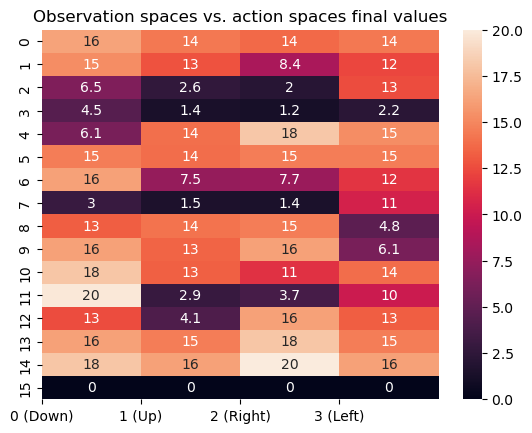

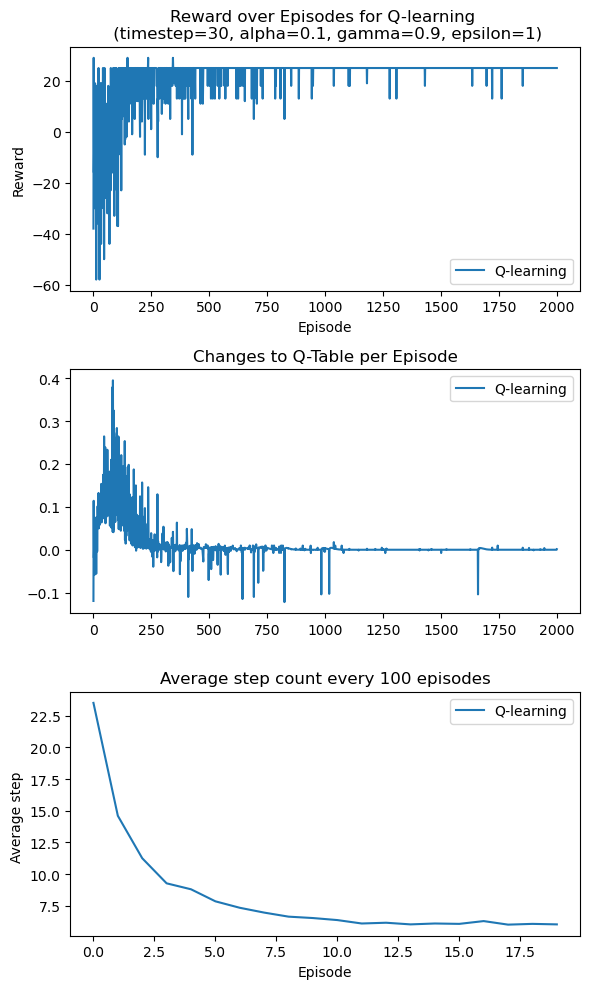

In [74]:
seaborn.heatmap(Q_q, annot=True)
plt.title("Observation spaces vs. action spaces final values")
plt.xticks([0,1,2,3],['0 (Down)', '1 (Up)', '2 (Right)', '3 (Left)'])
plt.show()

fig, axs = plt.subplots(3, 1, figsize=(6, 10))

axs[0].plot(reward_q, label='Q-learning')
axs[0].set_title(f'Reward over Episodes for Q-learning \n (timestep={timestep}, alpha={alpha}, gamma={gamma}, epsilon={epsilon})')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Reward')
axs[0].legend()

axs[1].plot(loss_q, label='Q-learning')
axs[1].set_title('Changes to Q-Table per Episode')
axs[1].legend()

axs[2].plot(avg_step_q, label='Q-learning')
axs[2].set_title("Average step count every 100 episodes")
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Average step ')
axs[2].legend()


plt.tight_layout()
plt.show()

# Turning Parameter

Parameter #1: Number of Max Timesteps

In [79]:
#define parameters
timestep=25
total_episodes = 2000
alpha = 0.1
gamma = 0.9
epsilon = 1
decay=(0.01/epsilon)**(1/total_episodes)

#define new environment
env = GameEnv(timestep)
env.reset()
Q_q, reward_q, loss_q, avg_step_q = Q_learning(env, timestep, total_episodes, alpha, gamma, epsilon, decay)

Episode 100 / 2000 complete
Current Q-table:
 [[ 0.          0.          4.20936452  0.        ]
 [ 5.70267604  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-1.897       0.          0.          0.        ]
 [ 2.50670874  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 6.1553368   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.         -0.7         0.          0.        ]
 [ 0.          0.         11.89442041  0.        ]
 [ 0.          0.         18.0304582   0.        ]
 [ 0.          0.          0.          0.        ]] 

Episode 200 / 2000 complete
Current Q-table:
 [[ 0.          0.         16.11168104  1.38345647]
 [18.0435631   0.          0.         

Episode 1400 / 2000 complete
Current Q-table:
 [[ 0.25100782  2.7889758  16.30979958  3.90913158]
 [18.12199997  3.09812296  0.          3.97795892]
 [ 0.1810039   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-1.897       5.0480462   0.          0.        ]
 [14.58        0.          0.36516055  0.47691486]
 [ 3.88145073  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [16.2         3.55592001  2.603165   -1.897     ]
 [13.87207796  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.         -0.7         0.          0.        ]
 [ 1.62        3.95107042 18.          0.        ]
 [ 3.42        2.46283283 20.          1.62      ]
 [ 0.          0.          0.          0.        ]] 

Episode 1500 / 2000 complete
Current Q-table:
 [[ 0.25100782  2.7889758  16.26011912  3.90913158]
 [18.1090451   3.09812296  0.       

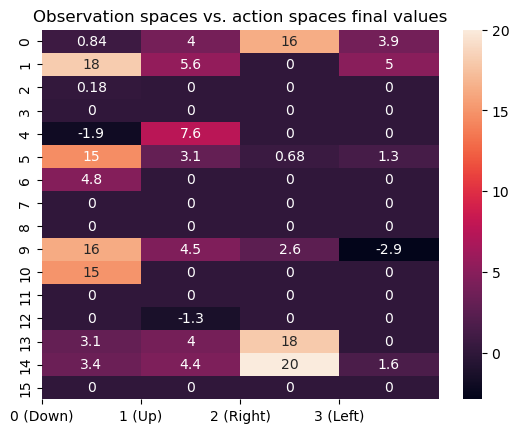

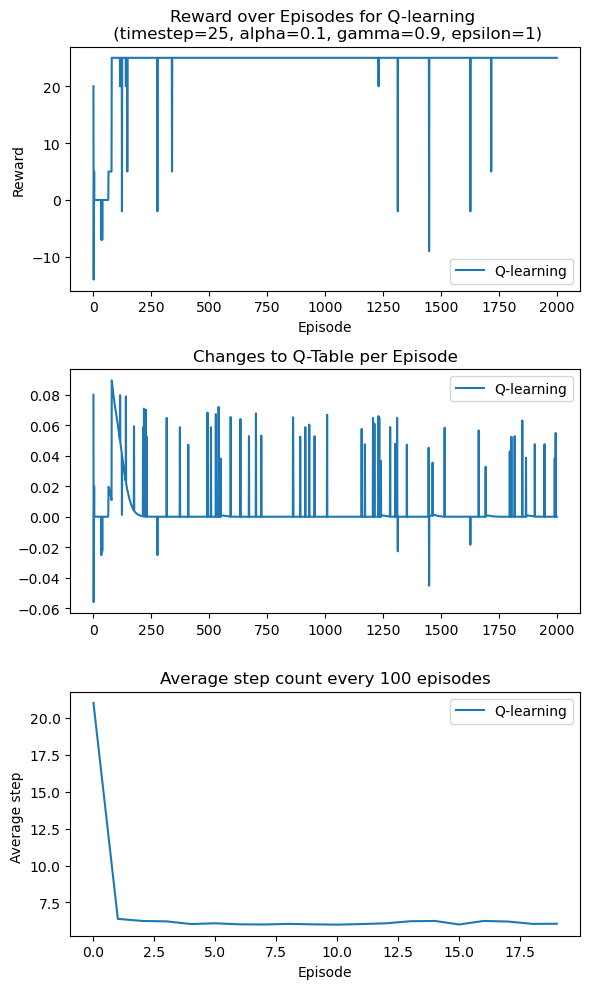

In [80]:
seaborn.heatmap(Q_q, annot=True)
plt.title("Observation spaces vs. action spaces final values")
plt.xticks([0,1,2,3],['0 (Down)', '1 (Up)', '2 (Right)', '3 (Left)'])
plt.show()

fig, axs = plt.subplots(3, 1, figsize=(6, 10))

axs[0].plot(reward_q, label='Q-learning')
axs[0].set_title(f'Reward over Episodes for Q-learning \n (timestep={timestep}, alpha={alpha}, gamma={gamma}, epsilon={epsilon})')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Reward')
axs[0].legend()

axs[1].plot(loss_q, label='Q-learning')
axs[1].set_title('Changes to Q-Table per Episode')
axs[1].legend()

axs[2].plot(avg_step_q, label='Q-learning')
axs[2].set_title("Average step count every 100 episodes")
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Average step ')
axs[2].legend()


plt.tight_layout()
plt.show()

In [81]:
#define parameters
timestep=20
total_episodes = 2000
alpha = 0.1
gamma = 0.9
epsilon = 1
decay=(0.01/epsilon)**(1/total_episodes)

#define new environment
env = GameEnv(timestep)
env.reset()
Q_q, reward_q, loss_q, avg_step_q = Q_learning(env, timestep, total_episodes, alpha, gamma, epsilon, decay)

Episode 100 / 2000 complete
Current Q-table:
 [[ 4.49861615  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.39005405  4.99986719  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.7       ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.         -1.897       0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]] 

Episode 200 / 2000 complete
Current Q-table:
 [[ 4.49999993  0.          0.          0.40499987]
 [ 0.          0.          0.         

Episode 1500 / 2000 complete
Current Q-table:
 [[ 2.41157982  0.          0.14982357  1.01992888]
 [ 2.23274578  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-6.37959433  1.91507461  2.74465174  1.91451545]
 [ 0.          0.83679663  0.          2.63217158]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.         -1.33      ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.         -2.4073      0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]] 

Episode 1600 / 2000 complete
Current Q-table:
 [[ 2.2611062   0.          0.14982357  1.01992888]
 [ 2.24966073  0.          0.       

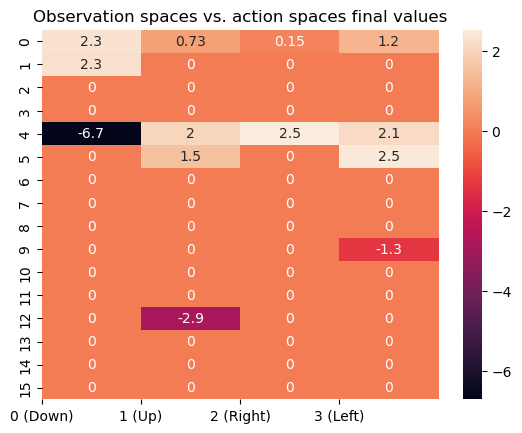

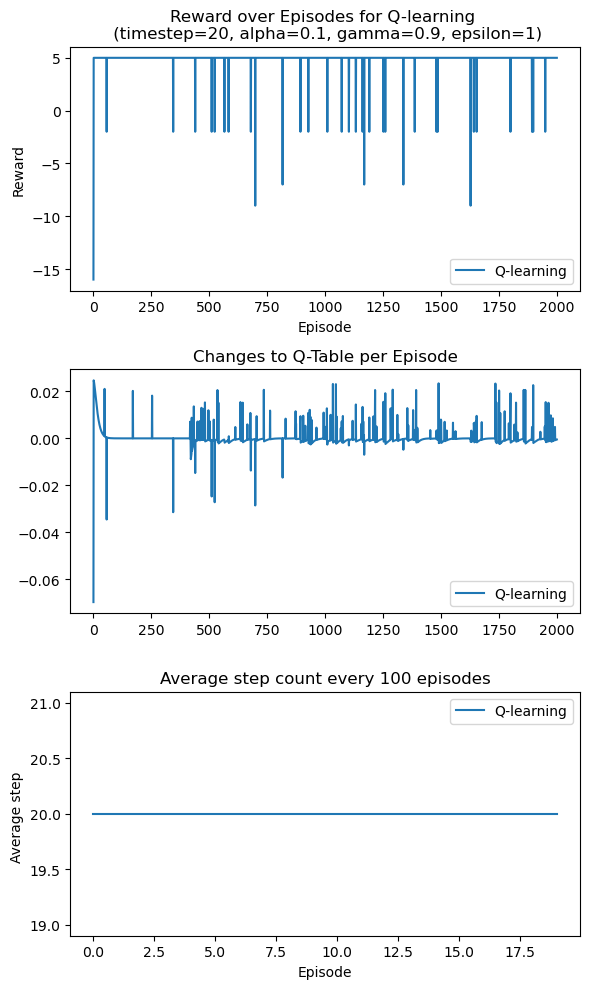

In [82]:
seaborn.heatmap(Q_q, annot=True)
plt.title("Observation spaces vs. action spaces final values")
plt.xticks([0,1,2,3],['0 (Down)', '1 (Up)', '2 (Right)', '3 (Left)'])
plt.show()

fig, axs = plt.subplots(3, 1, figsize=(6, 10))

axs[0].plot(reward_q, label='Q-learning')
axs[0].set_title(f'Reward over Episodes for Q-learning \n (timestep={timestep}, alpha={alpha}, gamma={gamma}, epsilon={epsilon})')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Reward')
axs[0].legend()

axs[1].plot(loss_q, label='Q-learning')
axs[1].set_title('Changes to Q-Table per Episode')
axs[1].legend()

axs[2].plot(avg_step_q, label='Q-learning')
axs[2].set_title("Average step count every 100 episodes")
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Average step ')
axs[2].legend()


plt.tight_layout()
plt.show()

Parameter #2: Decrease learning-rate (alpha)

In [83]:
#define parameters
timestep=15
total_episodes = 2000
alpha = 0.01
gamma = 0.9
epsilon = 1
decay=(0.01/epsilon)**(1/total_episodes)

#define new environment
env = GameEnv(timestep)
env.reset()
Q_q, reward_q, loss_q, avg_step_q = Q_learning(env, timestep, total_episodes, alpha, gamma, epsilon, decay)

Episode 100 / 2000 complete
Current Q-table:
 [[ 1.17243326e+00  4.05000000e-06  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.00000000e-02  0.00000000e+00  3.15135181e+00  1.23758849e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.00000000e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.00000000e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -7.00000000e-02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+0

Episode 1000 / 2000 complete
Current Q-table:
 [[ 3.42046826  0.04379273  0.          0.09035694]
 [ 0.18116927  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.85735284  0.33676077  3.8005413   0.35812073]
 [ 0.          0.00478193  0.          3.44567422]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.07      ]
 [ 0.          0.          0.         -0.07      ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.         -0.07        0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]] 

Episode 1100 / 2000 complete
Current Q-table:
 [[ 3.43066631  0.04379273  0.          0.09035694]
 [ 0.21034669  0.          0.       

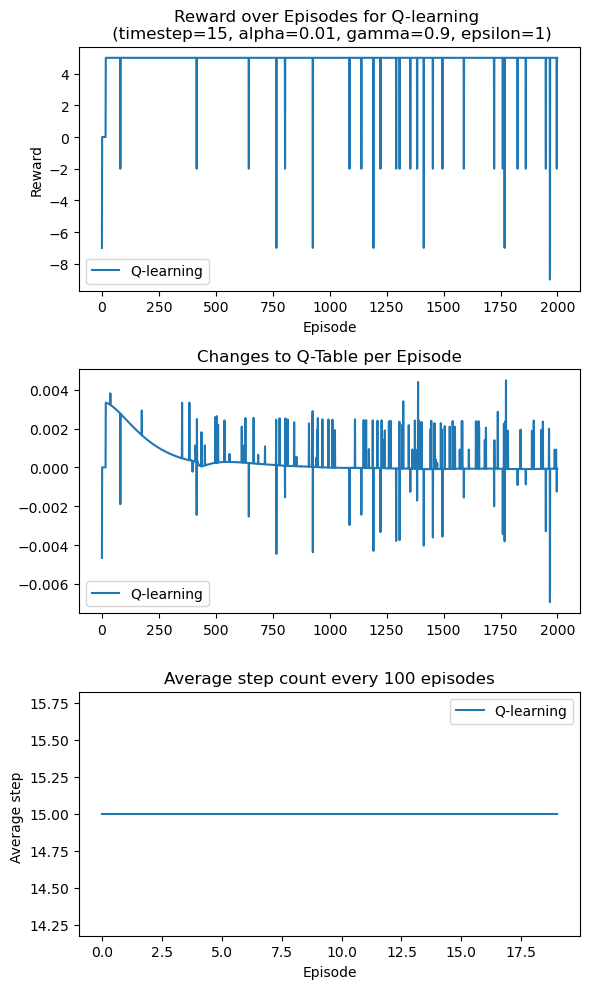

In [67]:
fig, axs = plt.subplots(3, 1, figsize=(6, 10))

axs[0].plot(reward_q, label='Q-learning')
axs[0].set_title(f'Reward over Episodes for Q-learning \n (timestep={timestep}, alpha={alpha}, gamma={gamma}, epsilon={epsilon})')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Reward')
axs[0].legend()

axs[1].plot(loss_q, label='Q-learning')
axs[1].set_title('Changes to Q-Table per Episode')
axs[1].legend()

axs[2].plot(avg_step_q, label='Q-learning')
axs[2].set_title("Average step count every 100 episodes")
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Average step ')
axs[2].legend()


plt.tight_layout()
plt.show()

**Explanation:** The set of hyperparameters used starts with a high level of exploration due to a high initial value for epsilon and a low decay rate. The learning-rate is also decreased which improves the Q-Table positive value.

Parameter #3: Decrease gamma

In [86]:
#define parameters
timestep=20
total_episodes = 2000
alpha = 0.01
gamma = 0.8
epsilon = 1
decay=(0.01/epsilon)**(1/total_episodes)

#define new environment
env = GameEnv(timestep)
env.reset()
Q_q, reward_q, loss_q, avg_step_q = Q_learning(env, timestep, total_episodes, alpha, gamma, epsilon, decay)

Episode 100 / 2000 complete
Current Q-table:
 [[ 0.90982964  0.00211783  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.07        0.          1.52218833  0.        ]
 [ 0.          0.          0.          1.1186048 ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.         -0.07        0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]] 

Episode 200 / 2000 complete
Current Q-table:
 [[ 1.06006694  0.02564987  0.          0.        ]
 [ 0.          0.          0.         

Episode 1000 / 2000 complete
Current Q-table:
 [[ 1.11092389e+00  3.42999777e-02  7.00234146e-04  8.89712132e-03]
 [ 1.45711828e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.32699442e+00  1.08807872e-01  1.38696915e+00  1.69773463e-01]
 [ 0.00000000e+00  3.13416689e-03  0.00000000e+00  1.13174160e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.07891102e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -7.00000000e-02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+

Episode 1900 / 2000 complete
Current Q-table:
 [[ 1.11320081  0.05985704  0.00260969  0.01781214]
 [ 0.3083736   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-1.90811269  0.22583082  1.38440237  0.32919284]
 [ 0.          0.02581799  0.          1.12695142]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.20628349  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.         -0.07        0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]] 

Episode 2000 / 2000 complete
Current Q-table:
 [[ 1.11748463  0.07638897  0.00260969  0.01781214]
 [ 0.33194118  0.          0.       

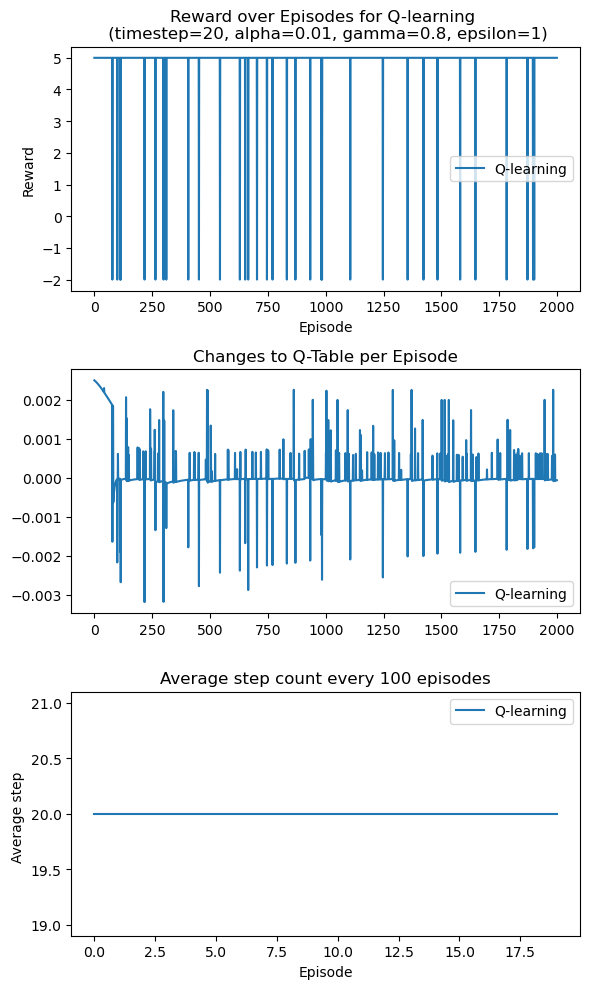

In [87]:
fig, axs = plt.subplots(3, 1, figsize=(6, 10))

axs[0].plot(reward_q, label='Q-learning')
axs[0].set_title(f'Reward over Episodes for Q-learning \n (timestep={timestep}, alpha={alpha}, gamma={gamma}, epsilon={epsilon})')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Reward')
axs[0].legend()

axs[1].plot(loss_q, label='Q-learning')
axs[1].set_title('Changes to Q-Table per Episode')
axs[1].legend()

axs[2].plot(avg_step_q, label='Q-learning')
axs[2].set_title("Average step count every 100 episodes")
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Average step ')
axs[2].legend()


plt.tight_layout()
plt.show()

**Explanation:** Low discount factors make agents focus on immediate rewards, leading to a policy that prioritizes obtaining positive rewards quickly.